<a href="https://colab.research.google.com/github/Gustavo-Martinez-Gutierrez/Gustavo_portfolio/blob/main/5_An%C3%A1lisis_de_Datos_Aplicados_a_la_Gesti%C3%B3n_ML_Supervisado_parte_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

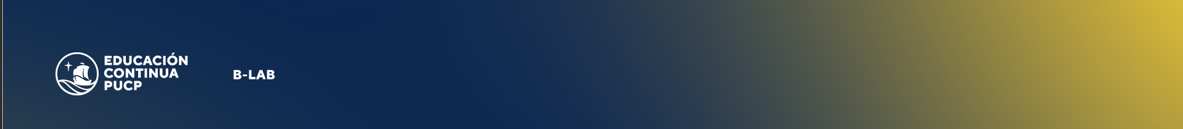

# 1. ML Supervisado - Modelos de Regresión

Como hemos mencionado en clases anteriores, los modelos de regresión sirven para poder encontrar una relación entre un target y un conjunto de variables. Esta relación puede ser lineal o no lineal. Para los ejemplos que veremos a continuación, utilizaremos un modelo de regresión lineal.

Existen múltiples aplicaciones de los modelos de regresión. A continuación, algunos ejemplos:
1. Operaciones y logística: queremos identificar qué factores influyen en el tiempo de entrega de un producto para mejorar la eficiencia. En este caso, podemos considerar como target el tiempo de entrega de un producto y explicarla por variables como la distancia de envío, la disponibilidad del producto en el inventario y otras variables que reflejen la eficiencia del proceso.
2. Gestión de RRHH: Queremos saber qué variables influyen en el % de rotación de los empleados. Al igual que en el caso anterior, podemos definir como target el % de rotación de empleados (en un área en específico o en una empresa) y explicarlo por variables como el salario, beneficios o indicadores de clima laboral.
3. Análisis de ventas: queremos saber qué variables influyen en las ventas de una empresa.

En esta sesión, abordaremos el siguiente ejemplo:

## 1.1. Ejemplo 1: Predicción de Ventas

Walmart ha proporcionado datos combinados de 45 tiendas, incluyendo información de las mismas y ventas mensuales. Los datos se proporcionan semanalmente. Walmart intenta encontrar el impacto de los días festivos en las ventas de las tiendas. Para ello, ha incluido en el conjunto de datos cuatro semanas de festividades: Navidad, Acción de Gracias, Super Bowl y Día del Trabajo.  Nuestro objetivo con este análisis es estudiar el conjunto de datos proporcionado.

Nuestro objetivo principal es predecir las ventas de la tienda en una semana.
El conjunto de datos proporciona información sobre el tamaño de la tienda y datos relacionados con el tiempo, por lo que se analizará si las ventas se ven afectadas por factores relacionados con el tiempo y el espacio.

La pregunta más importante es: ¿cómo la inclusión de feriados en una semana aumenta las ventas en la tienda?

In [ ]:
import numpy as np
import pandas as pd

# Para hacer gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Para funciones de fecha
import math
from datetime import datetime

# Para hacer modelos
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

In [ ]:
pd.options.display.max_columns=100

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_store = pd.read_csv('/content/drive/MyDrive/stores.csv') # Datos de tienda
df_train = pd.read_csv('/content/drive/MyDrive/train.csv') # Datos de entrenamiento
df_features = pd.read_csv('/content/drive/MyDrive/features.csv') # Variables externas

### 1.1.1. Análisis Exploratorio y Limpieza de Datos

In [ ]:
df_store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [ ]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [ ]:
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


Las bases de datos están en 3 archivos distintos, así que optaremos por reunirlas en uno solo.

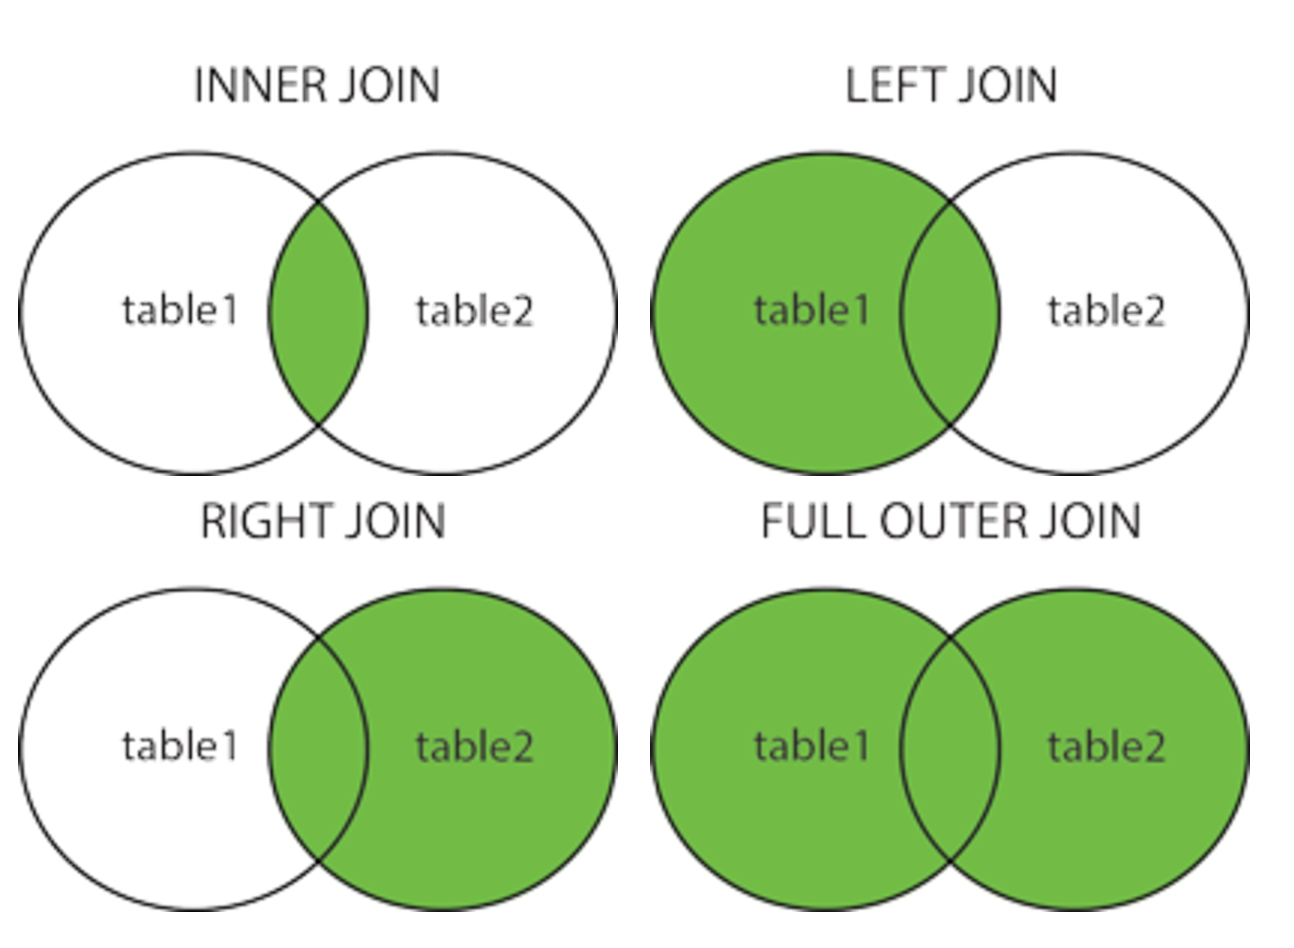

In [ ]:
# Haciendo el "merge" de las 3 bases de datos.
df = df_train.merge(df_features, on=['Store', 'Date'], how='inner').merge(df_store, on=['Store'], how='inner')
df.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


Podemos observar que hay una columna duplicada, así que la eliminaremos:

In [ ]:
df.drop(['IsHoliday_y'], axis=1,inplace=True)

Posteriormente, cambiaremos de nombre a la única columna que tiene feriados:

In [ ]:
df.rename(columns={'IsHoliday_x':'IsHoliday'},inplace=True)

Le damos una última mirada al dataframe:

In [ ]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


Walmart provee información sobre determinado número de tiendas y cada tienda tiene un departamento (comida, ropa, electro, etc.). Queremos ver cuántas tiendas hay y cuántos departamentos tenemos en total. ¿Vamos a querer pronosticar las ventas de cada departamento o a nivel de cada tienda? ¿o a nivel agregado? Esta es una de las preguntas que deben definirse al momento de especificar el requerimiento.

In [ ]:
df['Store'].nunique()

45

In [ ]:
df['Dept'].nunique()

81

Queremos ver cómo se comportan las ventas promedio semanales por departamento y por cada tienda.

In [ ]:
# Esta línea de código crea una tabla dinámica a partir del DataFrame:
# - Las filas de la tabla dinámica se agrupan por la columna Store.
# - Las columnas de la tabla dinámica se agrupan por la columna Dept.
# - Cada combinación fila / columna incluye la variable: Weekly_Sales.
# - Pero en cada combinación se reporta el promedio de las ventas.

store_dept_table = pd.pivot_table(df, index='Store', columns='Dept',
                                  values='Weekly_Sales', aggfunc=np.mean)
display(store_dept_table)

Dept,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,54,55,56,58,59,60,65,67,71,72,74,77,78,79,80,81,82,83,85,87,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,46102.090420,13150.478042,36964.154476,24257.941119,4801.780140,24566.487413,35718.257622,28062.052238,31033.386364,24919.270629,10566.545315,38692.880490,15268.550909,24151.061329,9196.557902,7765.304425,1259.018531,4091.571538,7808.450559,8052.076154,21623.184685,6187.389720,10152.336783,6767.997273,1374.649650,593.113986,4651.040210,3415.295035,2408.533287,8202.668392,5946.431189,11530.831678,2535.730909,1476.203566,2800.495105,79978.222587,NaN,58510.409161,1064.769650,7940.326224,NaN,4872.724406,23.995070,19662.989860,-116.454545,917.727920,11437.931259,NaN,32.712727,2355.439371,90.921053,12817.843357,4000.480629,3372.474476,857.775105,1020.995804,NaN,7436.017343,2732.473357,47390.644895,11652.827413,677.000000,11.500000,33974.792937,17139.314615,29780.696573,20727.860909,5704.048951,3685.875524,46006.277203,82427.547832,64238.943427,135458.969510,71699.182378,63180.568182,120772.062168,33251.831639,35207.348811,11827.770769,306.091081
2,30777.980769,65912.922517,17476.563357,45607.666573,30555.315315,6808.382517,40477.837063,58707.369441,34375.864476,38845.854476,23382.686154,7735.946294,46117.959231,21314.132937,27005.179650,13790.854196,11687.563009,4053.439930,5748.619441,9910.939860,12923.013846,29170.616573,8309.564545,15299.508392,9347.725105,1837.954615,798.913217,7111.482657,4981.155385,3884.756993,11755.096713,7488.096993,17595.203497,3875.588601,2631.750559,4500.250769,85114.996014,2.340000,78174.560210,2592.220769,8768.857692,NaN,7245.541189,29.139848,29675.324545,18.068182,1358.347914,15568.465664,NaN,16.226667,4148.373566,104.502868,13060.297692,5545.122308,21610.019091,1391.520559,221.545946,NaN,12125.255594,4634.609371,72929.496643,16986.406014,817.500000,11.764000,32759.096993,26041.273566,31000.484266,24647.232587,5710.719650,3672.042797,24932.985804,97611.537133,80610.380350,164840.230979,70581.977063,70018.672517,143588.751888,34319.063846,40697.204056,14035.400839,475.896905
3,7328.621049,16841.775664,5509.300769,8434.186503,11695.366573,2012.411818,10044.341608,8310.254196,9062.007692,10871.944126,8774.928042,2383.603007,11363.061678,4626.649021,7871.568322,2634.199650,2960.677739,731.313147,1682.199231,1244.529650,3101.769860,10913.330070,2763.627343,4260.447972,2850.050839,500.193636,166.870070,1517.404056,1243.926993,878.475455,4296.111049,3228.155105,4579.719161,1439.325524,622.689371,NaN,108598.364126,NaN,18203.108252,646.832028,4422.944406,NaN,2133.657762,9.922500,6179.259510,38.875000,NaN,17.581481,NaN,5.411803,961.390210,58.311239,7153.737902,1606.808881,NaN,244.878455,138.125874,NaN,2021.482657,1101.610000,22796.856573,3374.960769,424.000000,6.000000,7230.372448,24.420476,1429.300070,6746.578392,19.330000,874.128182,939.435455,1540.049161,318.685594,7568.280210,NaN,656.294444,15745.528252,3934.540000,343.437357,30.570833,NaN
4,36979.940070,93639.315385,19012.491678,56603.400140,45668.406783,8241.777692,50728.151399,62949.723776,34437.170979,37269.667413,27145.836643,8141.910979,69596.447343,28567.509441,21270.153007,15815.878042,13146.543790,3038.317762,8888.302867,8865.273147,17289.916294,46234.012867,10875.301189,15640.748531,18429.759930,2579.906154,916.232238,9472.121189,7683.686783,3813.243986,13685.430350,12304.056224,25142.675385,4376.574755,3005.231469,3640.752727,80093.946084,1.560000,78729.263077,975.417622,9511.818531,NaN,5441.563566,13.696939,39128.896154,23.536154,2324.615532,6911.676643,NaN,8.200000,3721.521329,131.887000,18662.627203,6040.540839,6078.142308,1586.446993,410.795105,NaN,12471.426713,7686.018741,101244.450839,20627.307762,344.571429,5.375000,52436.656923,19379.101399,31055.285315,29371.320979,9161.217343,2730.060000,14223.462308,8

Podemos ver que hay tiendas y departamentos con ventas negativas o iguales a cero. Vamos a ver quiénes son:

In [ ]:
df.loc[df['Weekly_Sales']<=0]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
188,1,47,2010-02-19,-863.00,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
406,1,47,2010-03-12,-698.00,False,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,A,151315
2549,1,47,2010-10-08,-58.00,False,63.93,2.633,NaN,NaN,NaN,NaN,NaN,211.746754,7.838,A,151315
3632,1,54,2011-01-21,-50.00,False,44.04,3.016,NaN,NaN,NaN,NaN,NaN,211.827234,7.742,A,151315
4132,1,47,2011-03-11,0.00,False,53.56,3.459,NaN,NaN,NaN,NaN,NaN,214.111056,7.742,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420066,45,49,2012-05-25,-4.97,False,67.21,3.798,5370.39,NaN,361.22,1287.62,2461.81,191.002810,8.567,B,118221
420403,45,49,2012-06-29,-34.00,False,75.22,3.506,3291.36,425.60,NaN,314.88,2255.34,191.099246,8.567,B,118221
420736,45,49,2012-08-03,-1.91,False,76.58,3.654,24853.05,39.56,17.96,11142.69,2768.32,191.164090,8.684,B,118221
421007,45,54,2012-08-31,0.00,False,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,191.461281,8.684,B,118221


Aquí tenemos dos posibilidades: dado que las ventas con este tipo de características son pocas, podemos:

- Eliminar las observaciones.
- Imputarles un valor de cero.

En nuestro caso le asignaremos un valor de cero.

In [ ]:
# Elegir una de las dos opciones para realizar la imputación:

#df['Weekly_Sales'] = df['Weekly_Sales'].replace(-np.inf, 0)
df['Weekly_Sales'] = df['Weekly_Sales'].clip(lower=0)

Ahora queremos ver la ventana temporal sobre la que vamos a estimar el modelo. Para ello, verenos las primeras 5 y las últimas 5 observaciones de la variable fecha

In [ ]:
df['Date'].head(5).append(df['Date'].tail(5))

<ipython-input-56-359e535bb597>:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df['Date'].head(5).append(df['Date'].tail(5))


0         2010-02-05
1         2010-02-05
2         2010-02-05
3         2010-02-05
4         2010-02-05
421565    2012-10-26
421566    2012-10-26
421567    2012-10-26
421568    2012-10-26
421569    2012-10-26
Name: Date, dtype: object

¿Se vende realmente más en feriado? Veremos cuáles son las ventas promedio según la variable IsHoliday:

<Axes: xlabel='IsHoliday', ylabel='Weekly_Sales'>

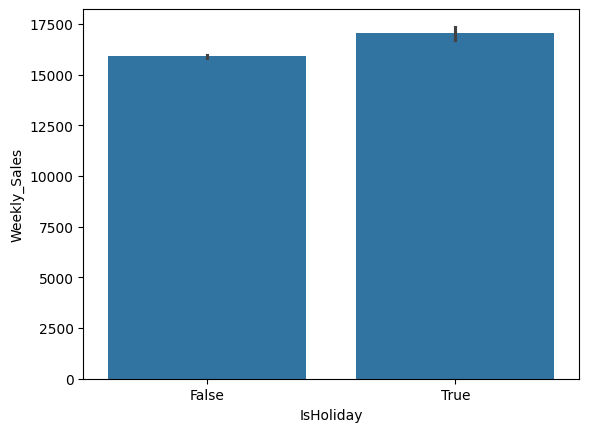

In [ ]:
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=df)

In [ ]:
df_holiday = df.loc[df['IsHoliday']==True]
df_holiday['Date'].unique()

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

Vamos a crear una columna por cada tipo de feriado:

In [ ]:
# Super bowl:
df.loc[(df['Date'] == '2010-02-12')|(df['Date'] == '2011-02-11')|(df['Date'] == '2012-02-10'),'Super_Bowl'] = True
df.loc[(df['Date'] != '2010-02-12')&(df['Date'] != '2011-02-11')&(df['Date'] != '2012-02-10'),'Super_Bowl'] = False

In [ ]:
# Día del trabajo:
df.loc[(df['Date'] == '2010-09-10')|(df['Date'] == '2011-09-09')|(df['Date'] == '2012-09-07'),'Labor_Day'] = True
df.loc[(df['Date'] != '2010-09-10')&(df['Date'] != '2011-09-09')&(df['Date'] != '2012-09-07'),'Labor_Day'] = False

In [ ]:
# Acción de gracias:
df.loc[(df['Date'] == '2010-11-26')|(df['Date'] == '2011-11-25'),'Thanksgiving'] = True
df.loc[(df['Date'] != '2010-11-26')&(df['Date'] != '2011-11-25'),'Thanksgiving'] = False

In [ ]:
# Navidad:
df.loc[(df['Date'] == '2010-12-31')|(df['Date'] == '2011-12-30'),'Christmas'] = True
df.loc[(df['Date'] != '2010-12-31')&(df['Date'] != '2011-12-30'),'Christmas'] = False

Luego podemos ver el promedio de ventas por cada uno de los feriados:

<Axes: xlabel='Christmas', ylabel='Weekly_Sales'>

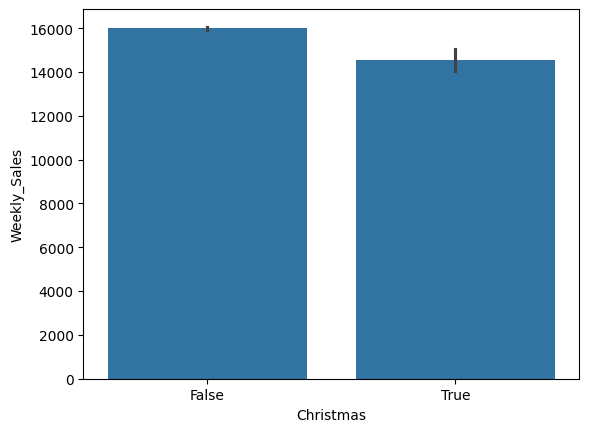

In [ ]:
sns.barplot(x='Christmas', y='Weekly_Sales', data=df)

<Axes: xlabel='Thanksgiving', ylabel='Weekly_Sales'>

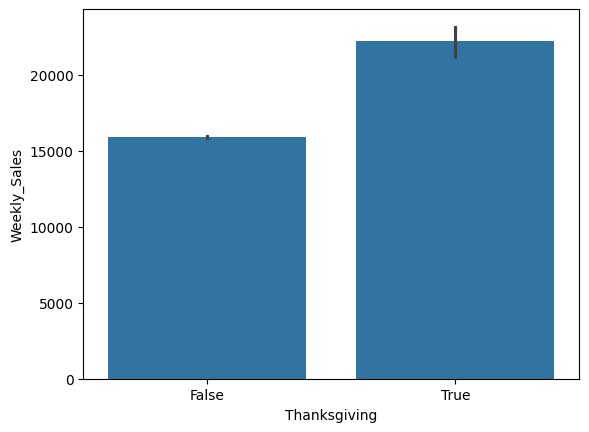

In [ ]:
sns.barplot(x='Thanksgiving', y='Weekly_Sales', data=df)

<Axes: xlabel='Super_Bowl', ylabel='Weekly_Sales'>

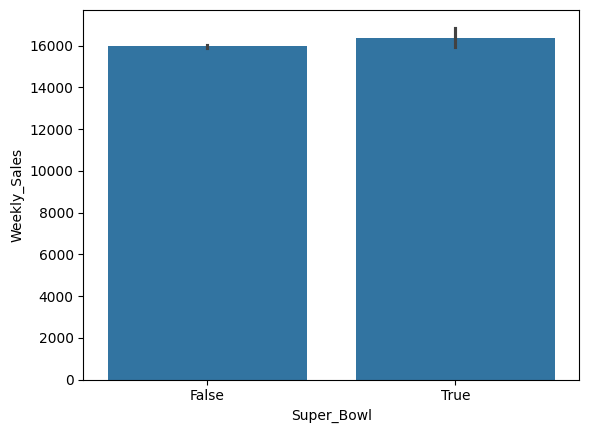

In [ ]:
sns.barplot(x='Super_Bowl', y='Weekly_Sales', data=df)

<Axes: xlabel='Labor_Day', ylabel='Weekly_Sales'>

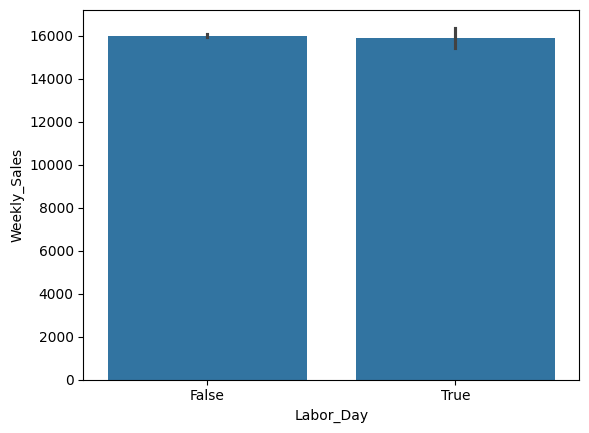

In [ ]:
sns.barplot(x='Labor_Day', y='Weekly_Sales', data=df)

En la base hay columnas de descuento ("Markdown"), que vimos que en muchos casos son valores missing. Les asignaremos un valor de cero.

In [ ]:
df.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
Super_Bowl           0
Labor_Day            0
Thanksgiving         0
Christmas            0
dtype: int64

In [ ]:
df = df.fillna(0)

In [ ]:
df.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
Super_Bowl      0
Labor_Day       0
Thanksgiving    0
Christmas       0
dtype: int64

In [ ]:
df.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.467250,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,136727.915739
std,12.785297,30.492054,22711.032446,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,60980.583328
min,1.000000,1.000000,0.000000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2079.650000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7612.030000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,140167.000000
75%,33.000000,74.000000,20205.852500,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


### 1.1.2. Construcción del Modelo

Tenemos 45 tiendas y 81 departamentos. Si queremos hacer un análisis de regresión para cada uno de ellos, tendríamos 3645 modelos. En lo que sigue, vamos a quedarnos con una tienda y un departamento en particular.

In [ ]:
df1 = df.query('Store == 20 and Dept == 72')

In [ ]:
df1.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas
187391,20,72,2010-02-05,173075.66,False,25.92,2.784,0.0,0.0,0.0,0.0,0.0,204.247194,8.187,A,203742,False,False,False,False
187461,20,72,2010-02-12,141187.54,True,22.12,2.773,0.0,0.0,0.0,0.0,0.0,204.385747,8.187,A,203742,True,False,False,False
187535,20,72,2010-02-19,122434.28,False,25.43,2.745,0.0,0.0,0.0,0.0,0.0,204.432100,8.187,A,203742,False,False,False,False
187607,20,72,2010-02-26,113539.16,False,32.32,2.754,0.0,0.0,0.0,0.0,0.0,204.463087,8.187,A,203742,False,False,False,False
187679,20,72,2010-03-05,119718.92,False,31.75,2.777,0.0,0.0,0.0,0.0,0.0,204.494073,8.187,A,203742,False,False,False,False


In [ ]:
df1.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,143.0,143.0,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.0
mean,20.0,72.0,91989.863217,55.451399,3.417608,4013.042867,1815.373007,956.883986,1934.258951,2159.098951,209.038131,7.371413,203742.0
std,0.0,0.0,51440.261925,16.543846,0.443029,8231.447936,9402.698654,8733.609037,5799.518501,4293.364349,4.176736,0.305069,0.0
min,20.0,72.0,47898.240000,20.390000,2.699000,0.000000,-0.990000,0.000000,0.000000,0.000000,203.610178,6.961000,203742.0
25%,20.0,72.0,65854.845000,42.865000,2.921000,0.000000,0.000000,0.000000,0.000000,0.000000,204.774194,7.139000,203742.0
50%,20.0,72.0,75958.980000,58.650000,3.541000,0.000000,0.000000,0.000000,0.000000,0.000000,208.556714,7.287000,203742.0
75%,20.0,72.0,98487.210000,70.330000,3.809000,6185.310000,70.000000,17.675000,1325.400000,3484.570000,213.372861,7.484000,203742.0
max,20.0,72.0,422306.250000,79.200000,4.066000,58928.520000,97740.990000,101378.790000,53603.990000,35675.620000,216.151590,8.187000,203742.0


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 187391 to 197532
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         143 non-null    int64  
 1   Dept          143 non-null    int64  
 2   Date          143 non-null    object 
 3   Weekly_Sales  143 non-null    float64
 4   IsHoliday     143 non-null    bool   
 5   Temperature   143 non-null    float64
 6   Fuel_Price    143 non-null    float64
 7   MarkDown1     143 non-null    float64
 8   MarkDown2     143 non-null    float64
 9   MarkDown3     143 non-null    float64
 10  MarkDown4     143 non-null    float64
 11  MarkDown5     143 non-null    float64
 12  CPI           143 non-null    float64
 13  Unemployment  143 non-null    float64
 14  Type          143 non-null    object 
 15  Size          143 non-null    int64  
 16  Super_Bowl    143 non-null    bool   
 17  Labor_Day     143 non-null    bool   
 18  Thanksgiving  143 non-

Vemos que las variables que corresponden a los feriados y que generamos anteriormente, son de tipo booleano (V/F). Dado que este tipo de variables no puede entrar directamente en las ecuaciones, vamos a convertirlas a tipo numérico para que puedan entrar en el modelo.

In [ ]:
df1['Super_Bowl'] = df1['Super_Bowl'].astype('int8')
df1['Labor_Day'] = df1['Labor_Day'].astype('int8')
df1['Thanksgiving'] = df1['Thanksgiving'].astype('int8')
df1['Christmas'] = df1['Christmas'].astype('int8')

<ipython-input-75-c6c47b0afe8b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Super_Bowl'] = df1['Super_Bowl'].astype('int8')
<ipython-input-75-c6c47b0afe8b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Labor_Day'] = df1['Labor_Day'].astype('int8')
<ipython-input-75-c6c47b0afe8b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

Vamos a trabajar con los formatos de fecha por si necesitamos desagregar la información por semanas o meses.

In [ ]:
 # Convertir a formato de fecha:
df1["Date"] = pd.to_datetime(df1["Date"])
df1['week'] =df1['Date'].dt.week
df1['month'] =df1['Date'].dt.month
df1['year'] =df1['Date'].dt.year

<ipython-input-76-e26f06e4e767>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["Date"] = pd.to_datetime(df1["Date"])
<ipython-input-76-e26f06e4e767>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df1['week'] =df1['Date'].dt.week
<ipython-input-76-e26f06e4e767>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['week'] =df1['Date'].dt.week
<ipython-input-76-e26f06e4e767>:4: SettingWithCopyWarning: 
A value is trying t

### Muestras de entrenamiento y validación

Para verificar que un modelo pueda ser aplicado a datos con los que no ha sido entrenado,

In [ ]:
train_data = df1[:int(0.7*(len(df1)))] # taking train part
test_data = df1[int(0.7*(len(df1))):] # taking test part

target = "Weekly_Sales"
used_cols = [c for c in df1.columns.to_list() if c not in [target]] # all columns except weekly sales

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

A partir de ahora trabajaremos con la muestra de entrenamiento (train).

### Análisis de la variable dependiente
Ahora vamos a examinar el comportamiento de la variable target. Una forma práctica de hacerlo es mediante una representación gráfica.

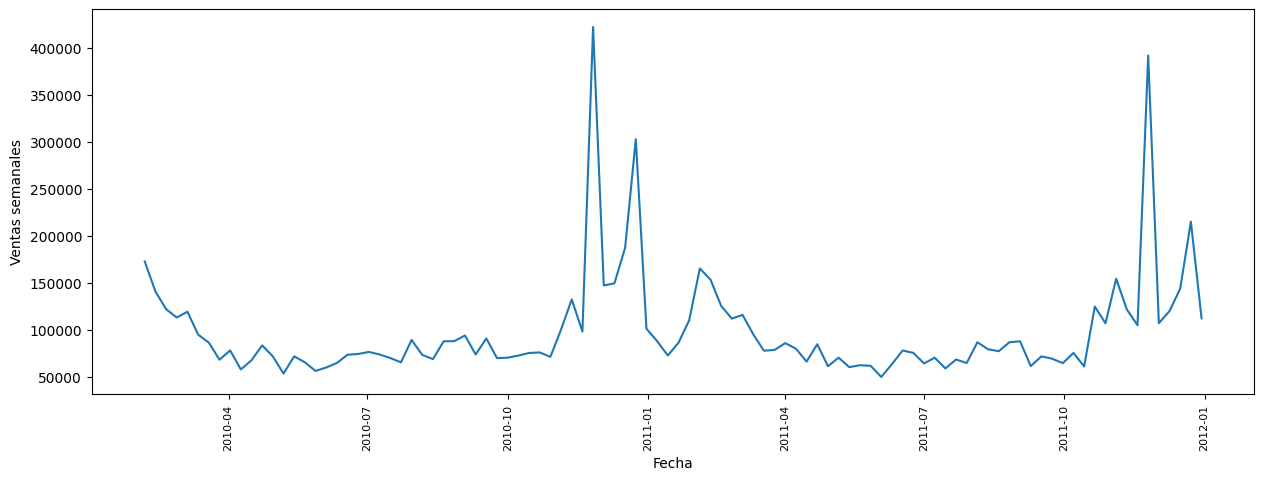

In [ ]:
# Graficar las ventas semanales
plt.figure(figsize=(15,5))
plt.plot(train_data['Date'], train_data['Weekly_Sales'])
plt.ylabel('Ventas semanales')
plt.xlabel('Fecha')
plt.xticks(rotation=90, fontsize=8)
plt.show()

Como pueden ver, el gráfico no es muy amigable ya que está graficando el comportamiento de las ventas día a día. Normalmente, cuando uno analiza datos diarios, estos suelen tener un componente mayor de ruido (factores que no se pueden explicar con variables observables), por lo que es mejor agregar los datos a nivel mensual o semanal para fines visuales.

Siguiendo el problema de negocio, nos interesa identificar los determinantes de las ventas de un departamento de la tienda a corto plazo, por lo que la frecuencia de análisis no debería ser mensual (las decisiones de abastecer una tienda son de plazos menores a eso).

Para poder analizar el comportamiento de las ventas a nivel semanal vamos a regresar nuevamente a trabajar con los formatos de fecha:

A continuación generamos una tabla dinámica para agregar los datos de ventas a nivel mensual:

<Axes: xlabel='month'>

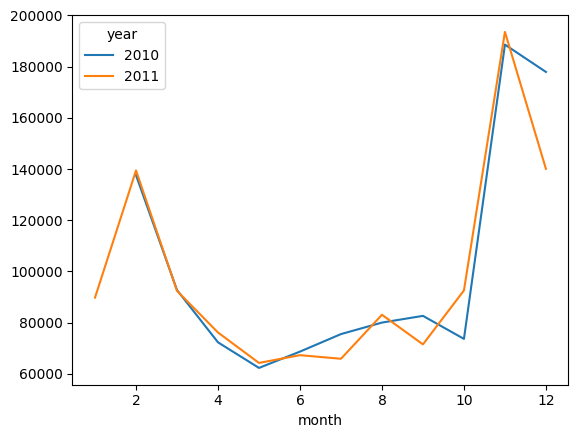

In [ ]:
monthly_sales = pd.pivot_table(train_data, values = "Weekly_Sales", columns = "year", index = "month")
monthly_sales.plot()

Lo mismo para los datos a nivel semanal:

<Axes: xlabel='week'>

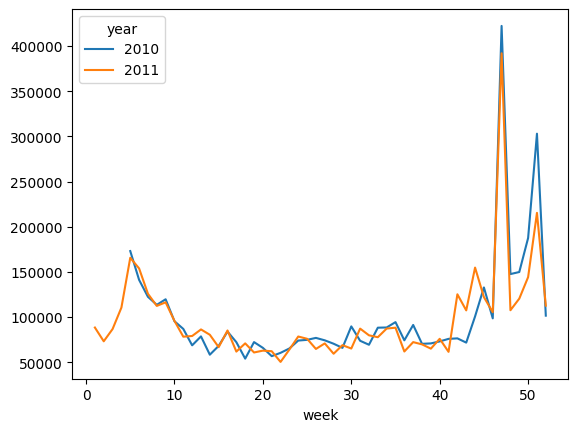

In [ ]:
weekly_sales = pd.pivot_table(train_data, values = "Weekly_Sales", columns = "year", index = "week")
weekly_sales.plot()

En ambos casos, es claro que existe un patrón estacional en las ventas, orientado sobre todo a inicios de año (SuperBowl) y fin de año.

### Análisis de Correlaciones:

Vamos a analizar la existencia de una relación lineal entre las variables. Para ello, utilizaremos el concepto de correlación.

La correlación lineal es una medida de la relación entre dos variables. Se utiliza para determinar si las variables están relacionadas y, en caso afirmativo, cómo.

La correlación lineal se expresa mediante un número entre -1 y 1. Un valor de 1 indica una correlación perfecta positiva, lo que significa que las variables aumentan o disminuyen juntas. Un valor de -1 indica una correlación perfecta negativa, lo que significa que las variables aumentan o disminuyen en direcciones opuestas. Un valor de 0 indica que no hay correlación entre las variables.

En nuestro caso, crearemos un df auxiliar con aquellas variables candidatas a formar parte del modelo y crearemos una matriz de correlaciones.

In [ ]:
train_data

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
187391,20,72,2010-02-05,173075.66,False,25.92,2.784,0.00,0.00,0.00,0.00,0.00,204.247194,8.187,A,203742,0,0,0,0,5,2,2010
187461,20,72,2010-02-12,141187.54,True,22.12,2.773,0.00,0.00,0.00,0.00,0.00,204.385747,8.187,A,203742,1,0,0,0,6,2,2010
187535,20,72,2010-02-19,122434.28,False,25.43,2.745,0.00,0.00,0.00,0.00,0.00,204.432100,8.187,A,203742,0,0,0,0,7,2,2010
187607,20,72,2010-02-26,113539.16,False,32.32,2.754,0.00,0.00,0.00,0.00,0.00,204.463087,8.187,A,203742,0,0,0,0,8,2,2010
187679,20,72,2010-03-05,119718.92,False,31.75,2.777,0.00,0.00,0.00,0.00,0.00,204.494073,8.187,A,203742,0,0,0,0,9,3,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194165,20,72,2011-12-02,107583.74,False,46.32,3.452,10007.34,60.00,25959.98,6140.65,35675.62,211.639431,7.082,A,203742,0,0,0,0,48,12,2011
194237,20,72,2011-12-09,120430.06,False,41.64,3.415,9458.19,81.50,791.04,5254.23,11447.14,211.866786,7.082,A,203742,0,0,0,0,49,12,2011
194311,20,72,2011-12-16,144247.36,False,37.16,3.413,5488.56,217.03,1776.71,466.19,4535.27,212.068504,7.082,A,203742,0,0,0,0,50,12,2011
194385,20,72,2011-12-23,215373.51,False,40.19,3.389,1483.17,80.15,2145.46,38.97,4180.29,212.236040,7.082,A,203742,0,0,0,0,51,12,2011


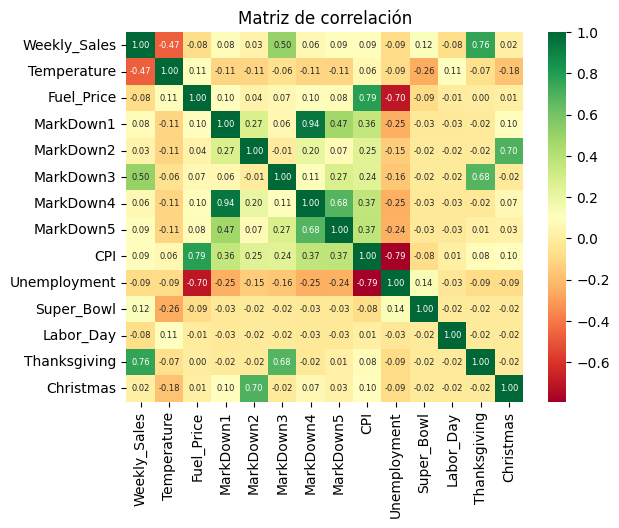

In [ ]:
# Filtrar las columnas necesarias
to_drop = ['Date','IsHoliday','Type','Store','Type','Dept','Size','week','month','year']
aux = train_data.drop(to_drop, axis=1)


# Calcular la matriz de correlación
corr = aux.corr()
# print(corr)

# Representar la matriz de correlación en un mapa de calor
annot_kws = {"size": 6}
sns.heatmap(corr, annot=True, fmt=".2f", cmap='RdYlGn', annot_kws=annot_kws)

plt.title('Matriz de correlación')
plt.show()

Podemos ver que las variables que se encuentran más relacionadas son las variables de temperatura, MarkDown3 y acción de gracias. Sin embargo, vamos a probar el modelo con todas las variables macroeconómicas y añadiremos una constante. El modelo que estimaremos será de la forma:

\begin{align}
    y_{t} = \beta_{0} + \beta_{1}x_{1t} +  \beta_{2}x_{2t} + ... + \beta_{k}x_{kt} + \epsilon_{t}
\end{align}

Donde $k$ es el número de features o variables a incluir, $t$ es el subíndice temporal, $x$ son los distintos features, y $\epsilon$ es el término de error.

Vamos a analizar tres formas posibles de estimar un modelo de regresión lineal:
- Usando statsmodels
- Usando statsmodels con fórmula
- Usando LinearRegression de scikit-learn

In [ ]:
# Filtrar las columnas necesarias
data = train_data[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'MarkDown3', 'CPI', 'Super_Bowl', 'Labor_Day', 'Thanksgiving','Christmas']]
data = sm.add_constant(data)

# Estimar el modelo de regresión lineal
model = sm.OLS(data['Weekly_Sales'], data[['const', 'Temperature', 'Fuel_Price', 'MarkDown3', 'CPI', 'Super_Bowl', 'Labor_Day', 'Thanksgiving', 'Christmas']])
results = model.fit()

# Imprimir los resultados del modelo
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           Weekly_Sales   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     42.16
Date:                Sat, 27 Jan 2024   Prob (F-statistic):           2.19e-27
Time:                        16:11:12   Log-Likelihood:                -1161.1
No. Observations:                 100   AIC:                             2340.
Df Residuals:                      91   BIC:                             2364.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.059e+06   3.73e+05     -2.842   

In [ ]:
# Filtrar las columnas necesarias
data = train_data[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Thanksgiving']]
data = sm.add_constant(data)

# Estimar el modelo de regresión lineal
model_1 = sm.OLS(data['Weekly_Sales'], data[['const', 'Temperature', 'Fuel_Price', 'CPI', 'Thanksgiving']])
results = model_1.fit()

# Imprimir los resultados del modelo
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           Weekly_Sales   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     82.72
Date:                Sat, 27 Jan 2024   Prob (F-statistic):           4.27e-30
Time:                        16:39:15   Log-Likelihood:                -1163.5
No. Observations:                 100   AIC:                             2337.
Df Residuals:                      95   BIC:                             2350.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -7.995e+05   3.51e+05     -2.280   

In [ ]:
# Define el modelo MCO con la fórmula
formula = 'Weekly_Sales ~ Temperature + Fuel_Price + MarkDown3 + CPI + Super_Bowl + Labor_Day + Thanksgiving + Christmas'
model = sm.OLS.from_formula(formula, data=train_data)

# Ajusta el modelo
results = model.fit()

# Imprime los resultados
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           Weekly_Sales   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     42.16
Date:                Sat, 27 Jan 2024   Prob (F-statistic):           2.19e-27
Time:                        16:44:27   Log-Likelihood:                -1161.1
No. Observations:                 100   AIC:                             2340.
Df Residuals:                      91   BIC:                             2364.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -1.059e+06   3.73e+05     -2.842   

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = train_data[['Temperature', 'Fuel_Price', 'MarkDown3', 'CPI', 'Super_Bowl', 'Labor_Day', 'Thanksgiving', 'Christmas']]
y = train_data['Weekly_Sales']

model = LinearRegression()

# Ajustar el modelo con los datos de entrenamiento
model.fit(X,y)

# Realizar predicciones en el conjunto de entrenamiento
y_pred = model.predict(X)

# Calcular el error cuadrático medio
mse = mean_squared_error(y, y_pred)
print(f'Error Cuadrático Medio: {mse}')

# Puedes imprimir los coeficientes y la intersección si lo deseas
print('Coeficientes:', model.coef_)
print('Intercepto:', model.intercept_)


Error Cuadrático Medio: 712186006.1139737
Coeficientes: [-1.42996663e+03 -3.36528829e+04 -5.82351961e-01  6.48390109e+03
  1.10042205e+04 -1.02462896e+04  3.22299684e+05 -2.86446984e+04]
Intercepto: -1059064.9292490918


Vamos a estimar el modelo sin algunas variables:

In [ ]:
# Define el modelo MCO con la fórmula
formula_2 = 'Weekly_Sales ~ Temperature + Fuel_Price + MarkDown3 + CPI + Super_Bowl + Labor_Day'
model_2 = sm.OLS.from_formula(formula_2, data=train_data)

# Ajusta el modelo
results_2 = model_2.fit()

# Imprime los resultados
print(results_2.summary())

                            OLS Regression Results                            
Dep. Variable:           Weekly_Sales   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     13.28
Date:                Sat, 27 Jan 2024   Prob (F-statistic):           8.24e-11
Time:                        16:54:13   Log-Likelihood:                -1207.6
No. Observations:                 100   AIC:                             2429.
Df Residuals:                      93   BIC:                             2447.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.701e+05   5.75e+05     -0.817      

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,  r2_score

X = train_data[['Temperature', 'Fuel_Price', 'MarkDown3', 'CPI', 'Super_Bowl', 'Labor_Day']]
y = train_data['Weekly_Sales']

model_3 = LinearRegression()

# Ajustar el modelo con los datos de entrenamiento
model_3.fit(X,y)

# Realizar predicciones en el conjunto de prueba
y_pred_3 = model_3.predict(X)

# Calcular el R cuadrado
r2 = r2_score(y, y_pred_3)
print(f'R^2: {r2}')

# Calcular el error cuadrático medio
mse = mean_squared_error(y, y_pred_3)
print(f'Error Cuadrático Medio: {mse}')

# Puedes imprimir los coeficientes y la intersección si lo deseas
print('Coeficientes:', model_3.coef_)
print('Intercepto:', model_3.intercept_)

R^2: 0.4613641602053772
Error Cuadrático Medio: 1805415046.4605927
Coeficientes: [-1.45190469e+03 -2.47501170e+04  2.52253401e+00  3.50866970e+03
  6.37692185e+03 -1.09292877e+04]
Intercepto: -470068.4050333788


### 1.1.3. Explicación de Resultados

Qué debemos incluir como parte de la explicación de los resultados del modelo. Los principales indicadores que debemos observar son.

* R-squared (R2): Es una medida que indica qué tan bien las variaciones en el target o la variable dependiente son explicadas por las variaciones en la variable independientes o features. Un R cuadrado cercano a 1 significa que una gran proporción de la variabilidad en la variable dependiente es explicada por el modelo. Por otro lado, un R cuadrado cercano a 0 indica que el modelo no explica mucho de la variabilidad observada.

* Prueba F: Se utiliza para evaluar la significancia general del modelo de regresión. Un valor grande del estadístico F, acompañado por un p-valor pequeño, sugiere que al menos una de las variables independientes en el modelo tiene un efecto significativo sobre la variable dependiente.

* Prueba t: Se utiliza para evaluar si la influencia de una variable independiente específica en el modelo es estadísticamente significativa. Si el valor absoluto del estadístico t es grande y el p-valor asociado es pequeño (generalmente, menor a 0.05), se considera que la variable es estadísticamente significativa en el modelo. Esto sugiere que hay evidencia suficiente para decir que esa variable tiene un impacto significativo en la variable dependiente.

### 1.1.4. Validación de Resultados

En nuestro caso, el objetivo del análisis es lograr un modelo predictivo para las ventas de esta tienda y departamento en particular. Hemos entrenado el modelo para una muestra en específico y queremos ver su capacidad de generalizar en una muestra nueva. Esta será nuestra muestra de validación o test. El mejor modelo será aquél que tenga una mejor performance en ambos tipos de muestra.

Una forma de medir el performance es el error cuadrático medio:
\begin{align}
  \text{MSE} = \sum^{T}_{i=1}(y_{t}-\hat{y}_{t})^{2}
\end{align}

Donde $y_{t}$ es el valor real del target, mientras que $\hat{y}_{t}$ es la predicción del target realizada por el modelo. Adicionalmente, tenemos la raíz cuadrada del error cuadrático medio, que viene dada por: $\text{RMSE}=\sqrt{\text{MSE}}$

Entre otros indicadores, también se puede analizar métricas como el $R^2$

In [ ]:
# En primer lugar, vamos a analizar el performance del modelo en la data de validación:
train_data_with_constant = sm.add_constant(train_data)
predictions_train = results.predict(train_data_with_constant)

test_data_with_constant = sm.add_constant(test_data)
predictions_test = results.predict(test_data_with_constant)

El error cuadrático medio de la muestra de entrenamiento viene dada por:

In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_train, predictions_train)
rmse = np.sqrt(mse)
print(f"Error Cuadrático Medio (MSE): {mse}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse}")

Error Cuadrático Medio (MSE): 799724554.8780239
Raíz del Error Cuadrático Medio (RMSE): 28279.401600423298


El error cuadrático medio de la muestra de validación (test) viene dada por:

In [ ]:
mse = mean_squared_error(y_test, predictions_test)
rmse = np.sqrt(mse)
print(f"Error Cuadrático Medio (MSE): {mse}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse}")

Error Cuadrático Medio (MSE): 542832353.2727906
Raíz del Error Cuadrático Medio (RMSE): 23298.76291292717


Por otro lado, el R2 puede definirse de la siguiente forma:

In [ ]:
from sklearn.metrics import r2_score

r2_train = r2_score(y_train, predictions_train)
r2_test = r2_score(y_test, predictions_test)

# Imprimir los resultados
print(f'R² en conjunto de entrenamiento: {r2_train}')
print(f'R² en conjunto de validación: {r2_test}')

R² en conjunto de entrenamiento: 0.7614064931686568
R² en conjunto de validación: 0.03474265275514754


Utilizando la librería scikit-learn:

In [ ]:
X_test = test_data[['Temperature', 'Fuel_Price', 'MarkDown3', 'Super_Bowl', 'Labor_Day']]
y_test = test_data['Weekly_Sales']

# Ajustar el modelo con los datos de entrenamiento
model_3.fit(X_test,y_test)

# Realizar predicciones en el conjunto de prueba
y_pred_4 = model.predict(X_test)

# Calcular el R cuadrado
r2 = r2_score(y_test, y_pred_4)
print(f'R^2: {r2}')

# Calcular el error cuadrático medio
mse = mean_squared_error(y_test, y_pred_4)
print(f'Error Cuadrático Medio: {mse}')

# Puedes imprimir los coeficientes y la intersección si lo deseas
print('Coeficientes:', model_3.coef_)
print('Intercepto:', model_3.intercept_)

R^2: 0.002186560329792586
Error Cuadrático Medio: 561140942.4952034
Coeficientes: [-6.83391947e+02  6.57468487e+03 -7.29975969e+00  7.57122917e+04
  2.11814341e+03]
Intercepto: 89366.33798406951
